# **Bài toán**

Khuôn mặt là một trong những đặc điểm sinh trắc học quan trọng nhất của con người. Bằng việc phân tích dữ liệu khuôn mặt, ta có thể thu thập được rất nhiều thông tin như tuổi tác, giới tính, chủng tộc, nhân dạng, biểu cảm,... Việc phân loại xác định giới tính là sử dụng hình ảnh từ khuôn mặt của một người bất kì để phân tích dự đoán người đó thuộc 1 trong 2 giới tính sinh học nam hoặc nữ. Một mô hình dự đoán giới tính hiệu quả có thể củng cố độ chính xác của mô hình nhận diện khuôn mặt, tăng hiệu quả tương tác giữa robot AI và thế giới xung quanh, tạo ra thêm nhiều dữ liệu cho các mô hình khác hoạt động, ...

In [27]:
import numpy as np  # Data manipulation
import pandas as pd # Dataframe manipulation 
import os
import random
import matplotlib.pyplot as plt # Plotting the data and the results
import matplotlib.image as mpimg # For displayinwg imagees
%matplotlib inline
from tensorflow import keras
from keras import models
from keras import layers
import keras.preprocessing as kp
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from skimage.transform import resize #resize image

# **Thông tin về dữ liệu**

Dữ liệu bao gồm gần 59 nghìn bức ảnh, được chia sẵn thành 2 tập Training (23.000 mẫu/loại) và Validation/Test (5.500 mẫu/loại), được tiền xử lí qua việc xác định và cắt khuôn mặt ra khỏi background, giúp giảm được nhiễu loạn trong dự đoán từ đó:

*   Khiến cho việc tính toán bớt nặng nhọc hơn cho cơ sở hạ tầng phần cứng hạn chế.
*   Mô hình để giải quyết vấn đề yêu cầu ít sự phức tạp hơn, giảm thời gian triển khai mô hình và có nhiều thời gian hơn cho tối ưu.

*   Giữ được sự ổn định trong dự đoán, giảm sai sót với những trường hợp đặc biệt mà mô hình chưa từng thấy.



Thông tin về bộ dữ liệu: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

Code dưới đây dùng cho việc tải lên dữ liệu và chạy mô hình trên Google Colab. **MyData.zip** là file nén zip phải được tải lên Google Drive trước đó, chứa toàn bộ dữ liệu cho việc huấn luyện và thử nghiệm mô hình. Hãy chạy đoạn code dưới nếu bạn đang chạy file này trên Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/archive.zip' -d '/content/data'

# **Tiền xử lí dữ liệu**

**Sơ kiểm dữ liệu:**

In [31]:
train=[len(os.listdir("data/Training/male")),len(os.listdir("data/Training/female"))]
val=[len(os.listdir("data/Validation/male")),len(os.listdir("data/Validation/female"))]
data_stat=pd.DataFrame([train,val], index=['train','val'], columns=['male','female'])
data_stat

,male,female
train,23766,23243
val,5808,5841


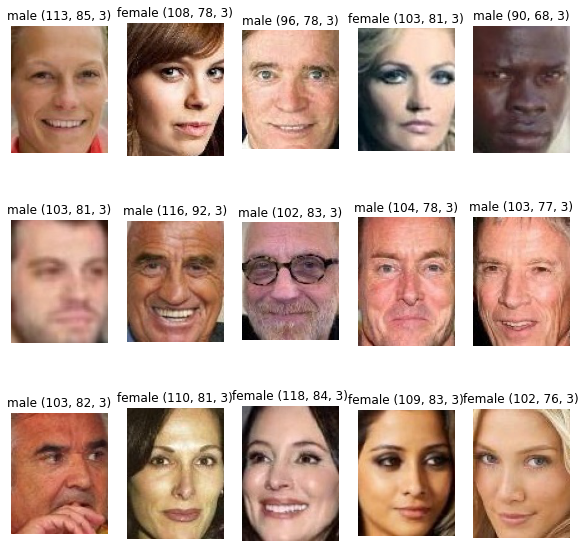

In [ ]:
tb_size=(3,5)

_,pic=plt.subplots(tb_size[0], tb_size[1],figsize=(10,10))
for i in range(tb_size[0]):
  for j in range(tb_size[1]):
    class_num = random.randrange(2)
    if (class_num==0):
      img_list=os.listdir('data/Validation/male')
      pic_num=random.randrange(len(img_list))
      pic_arr=keras.utils.img_to_array(keras.utils.load_img('data/Validation/male/'+ img_list[pic_num]))
      pic[i][j].imshow(pic_arr/255)
      pic[i][j].set_title('male '+ str(pic_arr.shape))
      pic[i][j].axis('off')
    else:
      img_list=os.listdir('data/Validation/female')
      pic_num=random.randrange(len(img_list))
      pic_arr=keras.utils.img_to_array(keras.utils.load_img('data/Validation/female/'+ img_list[pic_num]))
      pic[i][j].imshow(pic_arr/255)
      pic[i][j].set_title('female '+ str(pic_arr.shape))
      pic[i][j].axis('off')
    

Có thể thấy bộ dữ liệu gồm nhiều hình ảnh được cắt có kích thước đa dạng, để giảm thiểu độ phức tạp và tối ưu khả năng tính toán một cách thống nhất, ta cần có bước đưa tất cả các hình ảnh về cùng một kích thước. 

Hiếm khi có thể thấy được một vài ảnh bị đánh sai nhãn, có chất lượng tệ, bị mờ, chụp nửa mặt,... Tuy nhiên, vẫn khó có thể đánh giá chính xác liệu bộ dữ liệu có thật sự tốt hay không do có tới hàng nghìn bức ảnh và liệu sự ảnh hưởng của chúng có nhiều hay không. Do đó trước tiên ta cần lập thử mô hình, xem kết quả rồi đánh giá xem có cần thêm những biện pháp xử lí cho dữ liệu hay không.

**Xử lí dữ liệu sử dụng ImageDataGenerator:**

Các tham số rotate, shear, zoom lần lượt qui định độ xoay, mức độ thu phóng, tỉ lệ cắt của hình ảnh đầu vào sẽ được thực hiện một cách ngẫu nhiên. Những tham số này cùng nhiều tham số khác (không được sử dụng trong bài này) sẽ làm cho đầu vào trở nên nhiều và đa dạng từ đó góp phần không nhỏ trong việc dự đoán các trường hợp khó gặp khi so với mô hình chỉ được huấn luyện qua đầu vào chỉ gồm những bức hình không qua chỉnh sửa.

In [ ]:
rotate=30
shear=0.3
zoom=0.3
batch_s=48
img_s=(150,150)

Việc truyền bộ dữ liệu đầu vào sử dụng tính năng ImageDataGenerator của Tensorflow. Đây là một class đắc lực cho CV, cung cấp cho người dùng đa dạng các phương thức, khiến việc tạo nhập, điều chỉnh, chuẩn hóa dữ liệu dạng hình ảnh vô cùng đơn giản chỉ qua vài tham số, giúp tối ưu thời gian và công sức cho người sử dụng.


Ngoài ra, ImageDataGenerator còn giúp người dùng resize các hình về cùng một kích thước chỉ định và giúp chia dữ liệu ra thành từng batch nhỏ, từ đó việc huấn luyện trở nên nhanh và ổn định hơn.
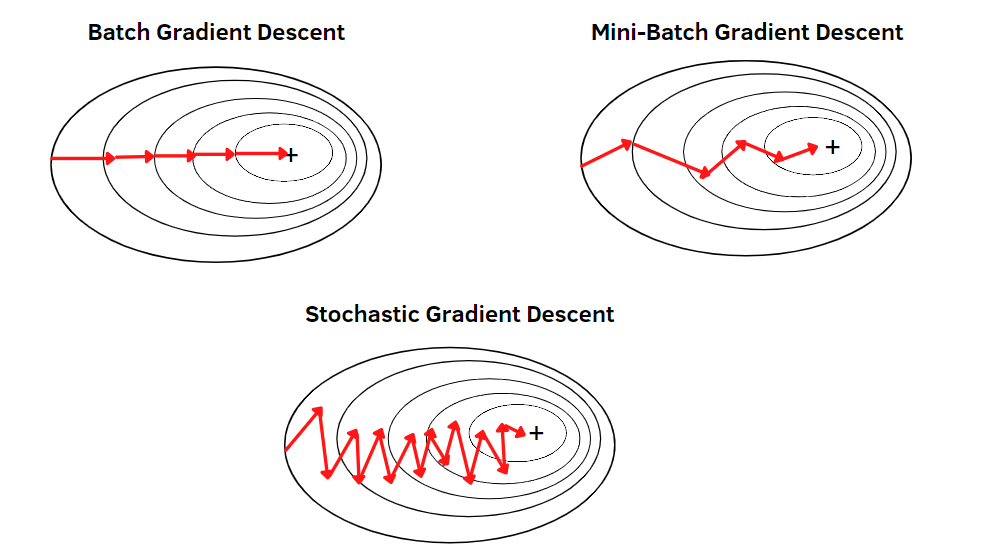

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=rotate,
                                   shear_range=shear,
                                   zoom_range=zoom)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen=train_datagen.flow_from_directory('/content/data/Training',
                                            target_size=img_s,
                                            batch_size=batch_s,
                                            class_mode='binary')

Found 47009 images belonging to 2 classes.


In [ ]:
valid_gen=test_datagen.flow_from_directory('/content/data/Validation',
                                           target_size=img_s,
                                           batch_size=batch_s,
                                           class_mode='binary')

Found 11649 images belonging to 2 classes.


**Cấu trúc dữ liệu sau khi nhập:**

Sau khi truyền, dữ liệu hình ảnh được lưu trữ lần lượt vào hai biến train_gen và valid_gen tương ứng với tập Training và Validation.

Bản chất của biến train_gen và valid_gen một loạt các tuple tương ứng với số batch, mỗi tuple bao gồm:
- 1 mảng 4 chiều chứa các mảng 3 chiều là giá trị của 3 kênh RGB được chuyển đổi từ hình ảnh
- 1 mảng 1 chiều chứa nhãn phân loại nam hoặc nữ tương ứng. 

Số lượng phần tử của hai mảng này tương ứng với kích thước của 1 batch.

In [ ]:
print("Chiều dài của train_gen tương ứng với số batch: ",len(train_gen))
print("Kiểu của từng phần tử trong train_gen: ", type(train_gen[0]))
print('Kích thước phần tử thứ nhất của mỗi tuple: ', train_gen[0][0].shape)
print('Kích thước phần tử thứ hai của mỗi tuple: ', train_gen[0][1].shape)

Chiều dài của train_gen tương ứng với số batch:  980
Kiểu của từng phần tử trong train_gen:  <class 'tuple'>
Kích thước phần tử thứ nhất của mỗi tuple:  (48, 150, 150, 3)
Kích thước phần tử thứ hai của mỗi tuple:  (48,)


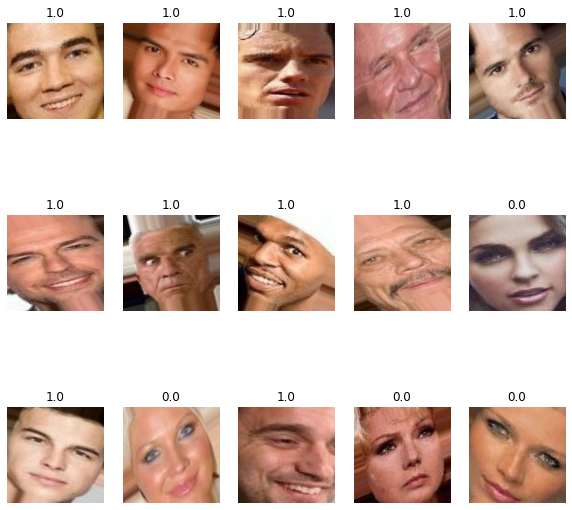

In [ ]:
tb_size=(3,5)

_,pic=plt.subplots(tb_size[0], tb_size[1],figsize=(10,10))
for i in range(tb_size[0]):
  for j in range(tb_size[1]):
    batch_num=random.randrange(980)
    indice = random.randrange(train_gen[batch_num][1].shape[0])
    
    pic[i][j].imshow(train_gen[batch_num][0][indice])
    pic[i][j].set_title(train_gen[batch_num][1][indice])
    pic[i][j].axis("off")

Như ta đã thấy, ImageDataGenerator đã thực hiện ngẫu nhiên, làm đa dạng các hình ảnh từ bộ dữ liệu gốc. Từ đây cũng có thể xác định được ImageDataGenerator đã đánh số phân loại 1 tương ứng với Nam và 0 tương ứng với Nữ.

# **Dựng mô hình**

In [ ]:
kernel_n=(32,64,256,256,128)
kernel_s=(3,3)
reg_type=regularizers.l2(0.001)

Một số tham số quan trọng được đặt chung để tiện cho việc điều chỉnh. 

Trong bài này sử dụng mô hình với 4 Convolutional Layers xen kẽ là các MaxPooling Layers và cuối cùng là lớp Dense/Fully Connected để đưa ra dự đoán.

Sơ lược về tác dụng của các lớp:

**Convolutional Layer:**

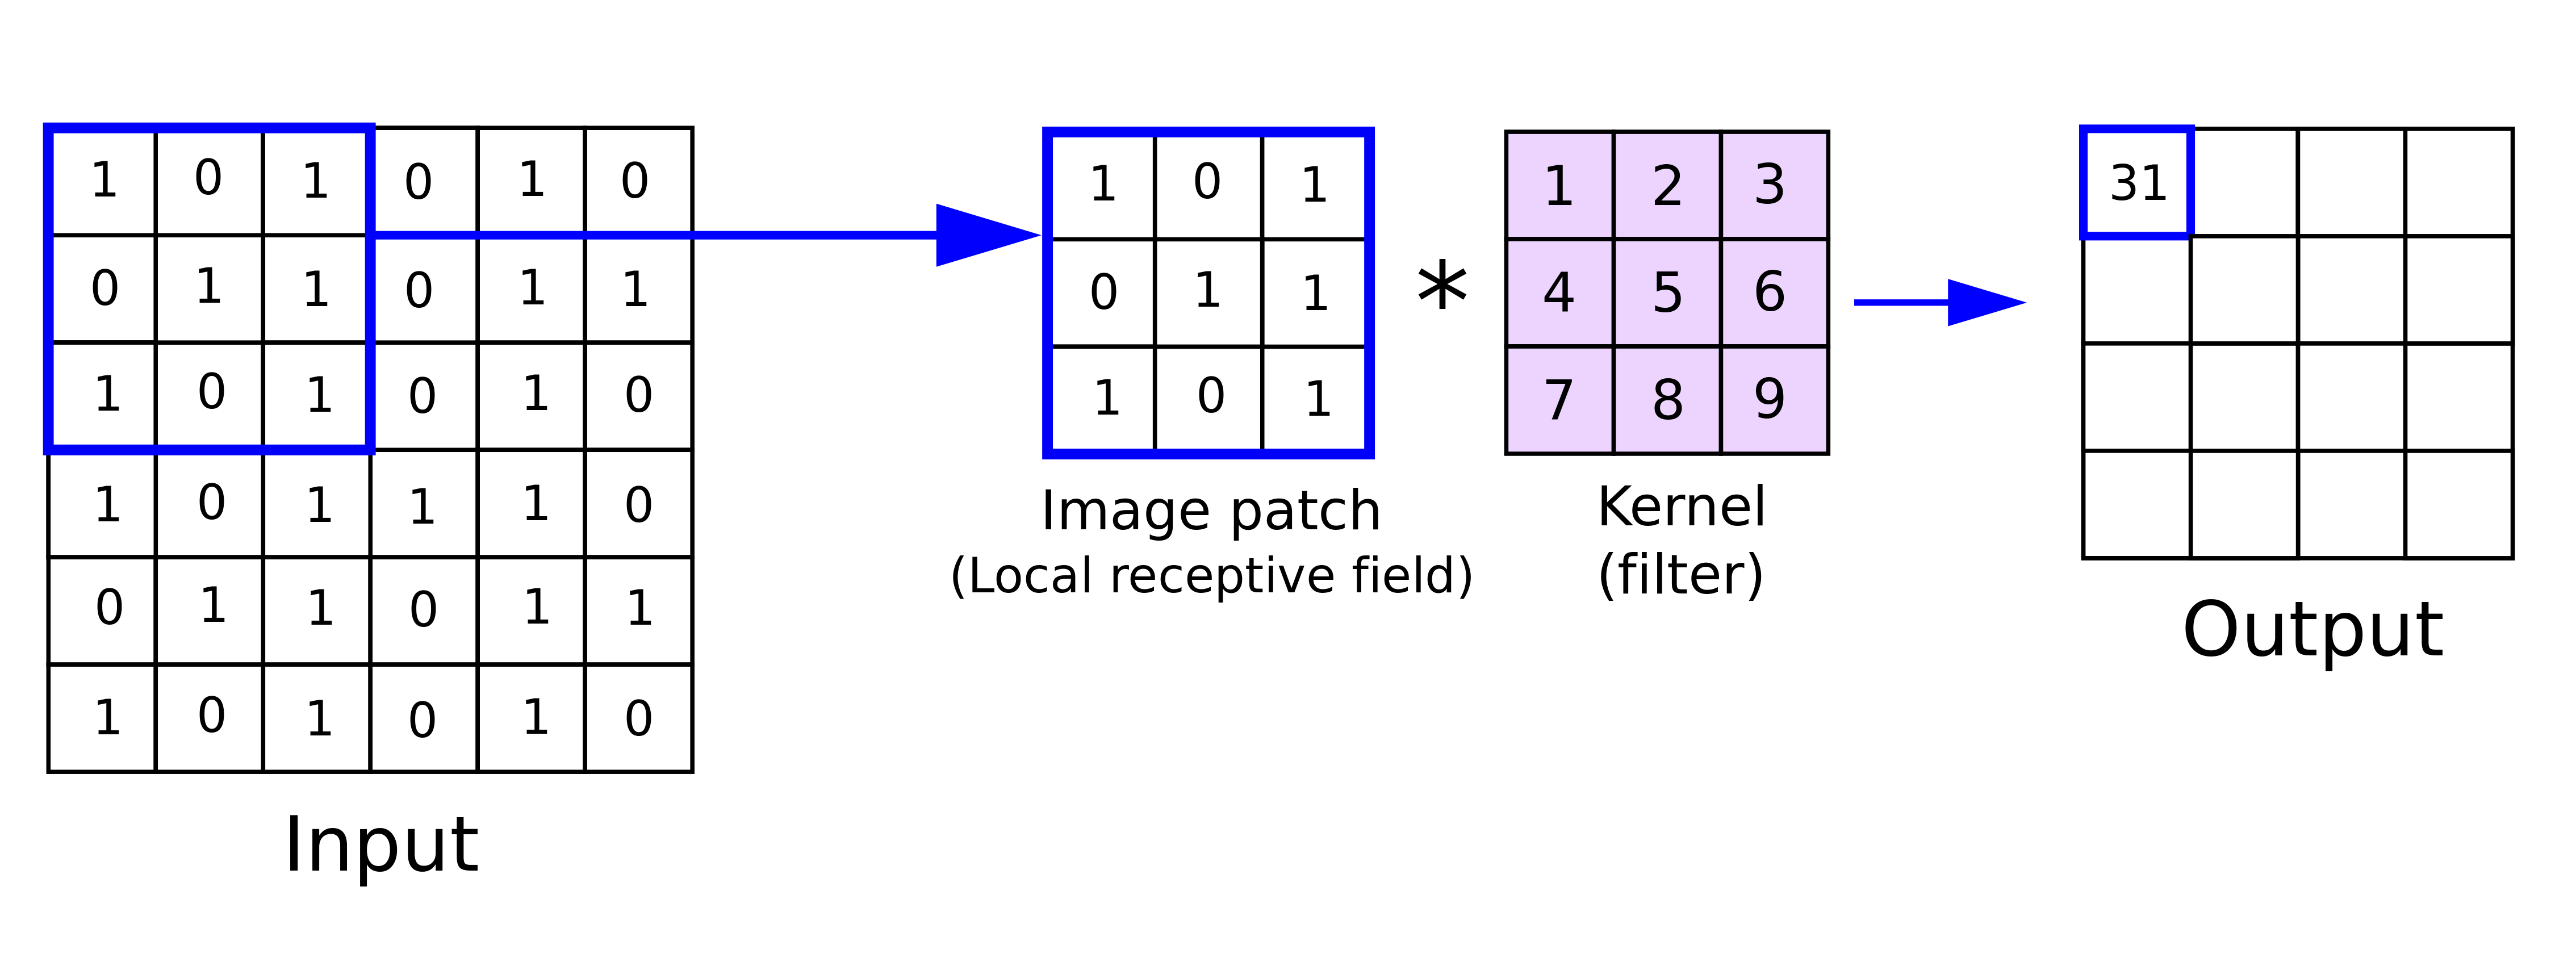
**MaxPooling Layer:** Là layer thường được chèn giữa các layer tích chập đóng vai trò tối ưu, truyền lại cho layer sau những giá trị tốt nhất và làm giảm kích thước đầu vào qua đó giảm được lượng lớn tham số của mô hình, giúp tăng tốc độ tính toán mà vẫn giữ được hiệu quả.

Các lớp **Fully Connected** cuối cùng nhằm mục đích tổng hợp những tinh túy được trích xuất từ các layer trước và đưa ra kết quả dự đoán.

Số kernel ở các layer và số layer được chỉnh bằng cách tăng dần độ phức tạp của mô hình, ngoài ra còn phải cân nhắc đến số lượng parameter phù hợp để mô hình không quá phức tạp với khả năng tính toán của máy mà vẫn giữ được độ chính xác tối ưu.

Sau khi nhận thấy mô hình với khoảng 1 triệu parameter là vừa đủ, cần xem xét đến việc bộ dữ liệu có ít sự nhiễu loạn do đã được cắt khuôn mặt từ trước, nên mục tiêu là muốn nhận dạng được nhiều đặc trưng nhất ở mức độ đơn giản. Do đó, tăng số kernel của các layer đầu và giữa nhiều hơn có thể là một cách hay.


Khi so sánh giữa mô hình có nhiều kernel ở các layer đầu và giữa (32,64,256,256,128) với mô hình có nhiều kernel ở các laye rcuối (32,64,64,128,128), kết quả cho thấy mô hình có nhiều kernel ở các layer đầu và giữa có kết quả cải thiện hơn mô hình còn lại khoảng 3-4%. 

Phần dữ liệu hình ảnh gốc có kích thước cực kì đa dạng được resize về cùng kích thước thành 150x150 pixel tương đối nhỏ và phần nào biến dạng. Do đó, kích thước filter (kernel) tiêu chuẩn 3x3 với no padding là lựa chọn tốt để không bị mất quá nhiều dữ liệu, đặc biệt là với ảnh đã được cắt sát mặt, khả năng cao mọi pixel đều có thông tin quan trọng.

L2 Regularzation được thêm vào với mức can thiệp vào Loss Function là nhỏ 0.001 để đề phòng hiện tượng Overfitting.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/model.h5")

In [ ]:
model=models.Sequential()

model.add(layers.Conv2D(kernel_n[0],
                        kernel_s,
                        activation='relu',
                        input_shape=(150,150,3),
                        kernel_regularizer=reg_type,
                        padding="valid")
)
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(kernel_n[1],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(kernel_n[2],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(kernel_n[3],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(kernel_n[4],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       147712    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 256)      0

In [ ]:
opt_type=keras.optimizers.RMSprop(learning_rate=0.0005)
steps=60
epoch_n=30

Bước chọn phương pháp tối ưu và learning rate và vô cùng quan trọng, chiếm phần lớn thời gian trong việc xây dựng mô hình. Bảng dưới đây so sánh hiệu quả mô hình ứng với các phương pháp, learning rate và epoch, step khác nhau.

Sau 30 epochs, 60 steps/epoch, mô hình đã xây dựng gần như đã đạt hiệu quả cao nhất có thể khi việc train thêm 10 epochs không giúp mô hình cải thiện thêm được gì.
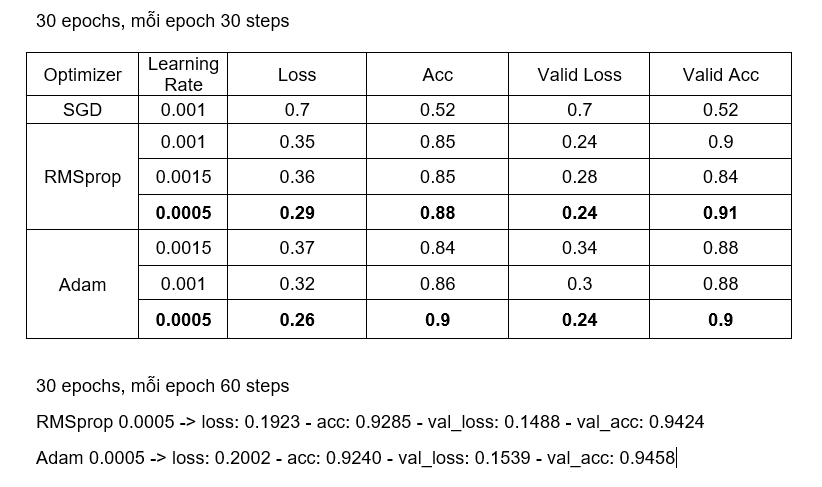

In [ ]:
model.compile(optimizer=opt_type,loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history=model.fit(train_gen,
                  steps_per_epoch=steps,
                  epochs=epoch_n,
                  validation_data=valid_gen,
                  validation_steps=steps)

Epoch 1/30
60/60 [==============================] - 29s 319ms/step - loss: 0.6995 - acc: 0.5396 - val_loss: 0.6849 - val_acc: 0.6976
Epoch 2/30
60/60 [==============================] - 19s 317ms/step - loss: 0.6162 - acc: 0.6691 - val_loss: 0.5046 - val_acc: 0.7573
Epoch 3/30
60/60 [==============================] - 21s 341ms/step - loss: 0.5183 - acc: 0.7580 - val_loss: 0.4446 - val_acc: 0.8059
Epoch 4/30
60/60 [==============================] - 18s 295ms/step - loss: 0.4775 - acc: 0.7896 - val_loss: 0.4461 - val_acc: 0.7962
Epoch 5/30
60/60 [==============================] - 18s 295ms/step - loss: 0.4259 - acc: 0.8208 - val_loss: 0.4054 - val_acc: 0.8267
Epoch 6/30
60/60 [==============================] - 18s 294ms/step - loss: 0.4046 - acc: 0.8212 - val_loss: 0.4102 - val_acc: 0.8184
Epoch 7/30
60/60 [==============================] - 18s 295ms/step - loss: 0.3904 - acc: 0.8330 - val_loss: 0.3178 - val_acc: 0.8698
Epoch 8/30
60/60 [==============================] - 18s 294ms/step - 

In [ ]:
model.save('model.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

NameError: ignored

Như mọi đồ thị ước lượng độ chính xác và hệ số mất mát của các mô hình sử dụng huấn luyện bằng các batch nhỏ, đường đi biểu diễn một cách gồ ghề và rất biến động nhưng nhìn chung vẫn giữ được xu hướng nhất định mà người triển khai mô hình muốn là giảm mất mát và tăng độ chính xác.

# **Kiểm tra độ chính xác của mô hình**






Ta dự đoán một lần nữa với bộ dữ liệu valid nhưng lần này với quy mô lớn hơn với 32 batch, mỗi batch 128 ảnh nhằm đưa ước lượng độ chính xác của mô hình tiến tới giá trị thực sự.


In [ ]:
test_datagen1 = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen1.flow_from_directory(
'/content/data/Validation',
target_size=(150,150),
batch_size=128,
class_mode='binary')

Found 11649 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_gen, steps=32)
print('test acc:', test_acc)
print('test_loss:',test_loss)

32/32 [==============================] - 12s 123ms/step - loss: 0.1855 - acc: 0.9443
test acc: 0.9443359375
test_loss: 0.18550211191177368


Có thể thấy được dù lúc huấn luyện có kết quả không quá cao nhưng khi thử lại với dữ liệu lớn hơn, độ chính xác của mô hình hoàn toàn có thể lên đến 95%.

4/4 [==============================] - 0s 12ms/step
Do chinh xac du doan:  0.8984375


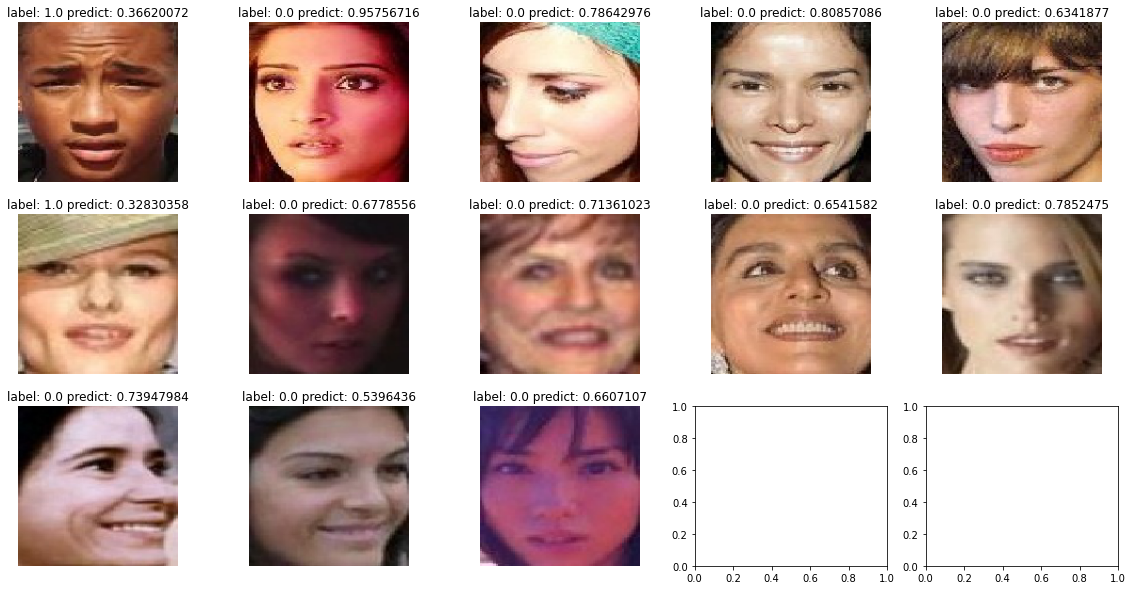

In [ ]:
batch_num=random.randrange(len(test_gen))
poss_pre=model.predict(test_gen[batch_num][0]).reshape(-1)
predict=poss_pre.round()
label=test_gen[batch_num][1]
diff_arr=abs(predict - label)
diff_num=int(sum(abs(predict - label)))
print('Do chinh xac du doan: ', 1-diff_num/len(diff_arr))
_, pic = plt.subplots(max(2,int(np.ceil(diff_num/5))), 5, figsize=(20,10))
row=0
col=0
for i in range(len(diff_arr)):
  if diff_arr[i] != 0:
    pic[row][col].imshow(test_gen[batch_num][0][i])
    pic[row][col].set_title('label: '+str(label[i])+ ' predict: '+str(poss_pre[i]))
    pic[row][col].axis("off")
    col=col+1
    if col==5:
      row=row+1
      col=0
plt.show()

Từ kết quả trên, ta có thể thấy phần lớn các hình dự đoán sai là từ những dữ liệu có:
- Khuôn mặt nam, nhãn male, dự đoán female
- Khuôn mặt nữ, nhãn male, dự đoán female

Có thế thấy nguyên nhân cho sự sai sót là **do các hình ảnh bị đánh sai nhãn từ đầu**, mà đặc biệt là các hình ảnh có khuôn mặt nữ nhưng lại được đánh nhãn là male. Một điều nữa là những khuôn mặt nữ bị đánh sai nhãn ấy có độ chính xác trong dự đoán rất cao, từ đó thấy được các ảnh thuộc **class female ít bị đánh sai nhãn hơn.** Điều này làm mô hình bị nhiễu loạn khi cố gắng đánh giá các hình ảnh có nhãn thật sự là male. Ngoài ra, do độ chính xác trên tập train và trên tập valid tương đương nhau nên có khả năng tập train cũng mang tình trạng tương tự.

Ngoài những hình cho ra kết quả dự đoán khác với kết quả của nhãn như trên, rất có thể còn có nhiều hình bị đánh sai nhãn nhưng cho ra kết quả dự đoán giống với nhãn.

Do đó, cần có biện pháp để kiểm tra lại tính đúng đắn của bộ dữ liệu với hàng ngàn mẫu một cách nhanh chóng và sửa chữa lại. Đây cũng là một cách để tăng hiệu quả, giúp ta thấy được độ chính xác thực sự của mô hình do việc có được một bộ dữ liệu chính xác sẽ làm giảm sự nhiễu loạn không đáng có trong dự đoán.

Tiếp theo, chúng ta sẽ dùng 1 bộ dữ liệu Test hoàn toàn khác, các hình ảnh sẽ không được cắt sát mặt mà sẽ còn background, để kiểm tra mô hình có còn hoạt động tốt không. Quy mô tương tự với lần dự đoán trước đó: 32 batch, mỗi batch 128 hình ảnh.

In [ ]:
!unzip '/content/drive/MyDrive/Test.zip' -d '/content/data/test'

In [35]:
test_datagen2 = ImageDataGenerator(rescale=1./255)
test_gen2 = test_datagen2.flow_from_directory(
'/content/data/Test',
target_size=(150,150),
batch_size=128,
class_mode='binary')

Found 20001 images belonging to 2 classes.


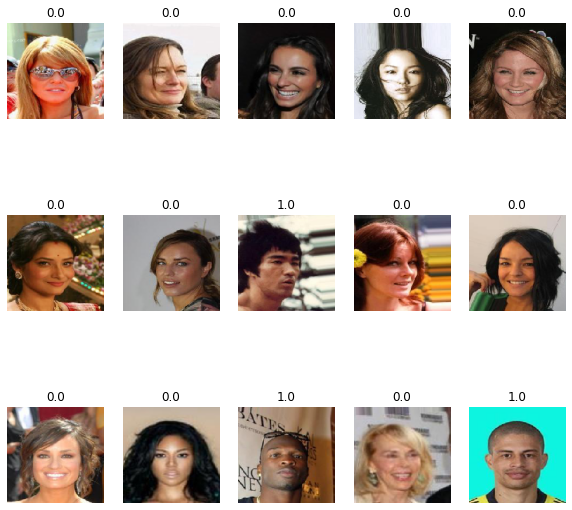

In [47]:
tb_size=(3,5)

_,pic=plt.subplots(tb_size[0], tb_size[1],figsize=(10,10))
for i in range(tb_size[0]):
  for j in range(tb_size[1]):
    batch_num=random.randrange(157)
    indice = random.randrange(test_gen2[batch_num][1].shape[0])
    
    pic[i][j].imshow(test_gen2[batch_num][0][indice])
    pic[i][j].set_title(test_gen2[batch_num][1][indice])
    pic[i][j].axis("off")

In [59]:
test_loss, test_acc = model.evaluate(test_gen2, steps=32)
print('test acc:', test_acc)
print('test_loss:',test_loss)

32/32 [==============================] - 6s 176ms/step - loss: 1.1817 - acc: 0.4248
test acc: 0.4248046875
test_loss: 1.1817216873168945


Accuracy của lần dự đoán này rất thấp, có vẻ như là hình ảnh phải được cắt sát mặt thì mô hình này mới dự đoán đúng được. Sau đây ta sẽ kiểm chứng lại bằng cách so sánh kết quả của từng cặp hình ảnh trước và sau khi cắt sát mặt:

In [60]:
# new data from outside kaggle website to test on it.
male_path = '/content/drive/MyDrive/test2/male/'
female_path = '/content/drive/MyDrive/test2/female/'

In [61]:
# function that display image, its gender and percentage of gender.
def show_image(im, row, col, result):
    if int(result*2) >= 1:
        percentage = (round(float(((result[0]-0.5 ) +0.5 )* 100 ),2))
        title = f"Male:{percentage}%"
    else:
        percentage = (round(float(((0.5-result[0])+0.5)* 100 ),2))
        title = f"Female:{percentage}%"
    
    ax[row][col].imshow(im)
    ax[row][col].set_title(title)
    ax[row][col].axis("off")

1/1 [==============================] - 0s 20ms/step


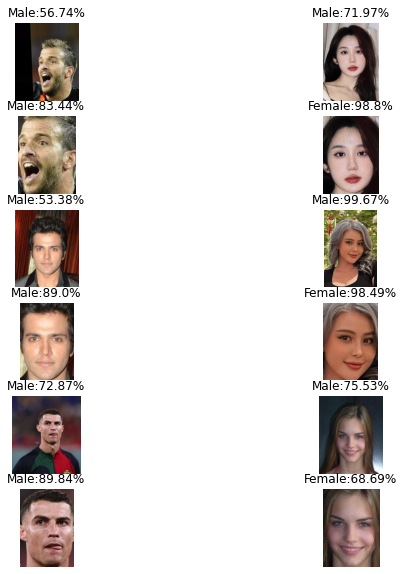

In [62]:
from skimage.transform import resize
# create subplot for outside image.
fig, ax = plt.subplots(6,2,figsize=(10,10))

# loop on new image predict and display.
for row in range(6):
    im_0 = plt.imread(male_path + str(row+1) + '.jpg')
    im_1 = plt.imread(female_path + str(row+1) + '.jpg')
    
    im_0_resize = resize(im_0, (150,150))
    im_1_resize = resize(im_1, (150,150))
    
    im_0_resize = np.expand_dims(im_0_resize, axis =0)
    im_1_resize = np.expand_dims(im_1_resize, axis =0)
    
    result_0 = model.predict(im_0_resize)
    result_1 = model.predict(im_1_resize)
    
    show_image(im_0, row, 0, result_0)
    show_image(im_1, row, 1, result_1)
    
plt.show()

**Nhận xét**

